# Report on load testing

## Search query

In the search endpoint, we use a query similar to:
```
select *
from "user"
where first_name like 'Иван%'
    and last_name like 'Попов%'
    and deleted = false;
```

(Note: I have a `deleted` field to manage deletions for user withour actual removals from db)

Running `explain` on it, we see that it is realized via sequential scan:

```
QUERY PLAN
Gather  (cost=1000.00..42336.90 rows=239 width=248)
  Workers Planned: 2
"  ->  Parallel Seq Scan on ""user""  (cost=0.00..41313.00 rows=100 width=248)"
        Filter: ((NOT deleted) AND ((first_name)::text ~~ 'Иван%'::text) AND ((last_name)::text ~~ 'Попов%'::text))
```


## Creating index

I create an index on these columns in the same order as in `where`, enabling `text_pattern_ops` on text columns, so the index can be used for `like 'text%'` filters:

```
CREATE INDEX idx_user_first_name_last_name_deleted ON "user" (first_name text_pattern_ops, last_name text_pattern_ops, deleted);
```


Now we see that query planner want to run the same query via bitmap index scan:

```
QUERY PLAN
"Bitmap Heap Scan on ""user""  (cost=834.23..1705.45 rows=239 width=248)"
  Filter: ((NOT deleted) AND ((first_name)::text ~~ 'Иван%'::text) AND ((last_name)::text ~~ 'Попов%'::text))
  ->  Bitmap Index Scan on idx_user_first_name_last_name_deleted  (cost=0.00..834.17 rows=231 width=0)
        Index Cond: (((first_name)::text ~>=~ 'Иван'::text) AND ((first_name)::text ~<~ 'Ивао'::text) AND ((last_name)::text ~>=~ 'Попов'::text) AND ((last_name)::text ~<~ 'Попог'::text) AND (deleted = false))
```



## Load test

I performed the load test on `/user/search` with and without the index using Locust framework in python.

The db was seeded with 1 million rows of data from the csv file offered on the course website. For the test, in each request I would randomly choose a first & last name combo that exists in the db, and search for it.

I used the following load shape for the 4 stages of the test:
- 4 minutes of 1 concurrent users, 1 user/s spawn rate
- 4 minutes of 10 concurrent users, 10 user/s spawn rate
- 4 minutes of 100 concurrent users, 100 user/s spawn rate
- 4 minutes of 1000 concurrent users, 1000 user/s spawn rate

## Load test analysis

For each of the 4 load phases, I removed first 100 seconds from analysis to look at the stationary state of the system under load.

Below (under the code block) you can see the graphs of 4 key metrics: throughput, latency at 50%, 90% and 95% quantiles.

We can compare the data at different loads, and in presence vs in absence of index.

Key takeaways:
- Upon increasing load, throughput saturates and does not grow after some point. 
- On the other hand, latency degrades (grows) as the load increases.
- The addition of a good index can grow throughput by 5-10x, and decrease latency by 5-10x
- If we want reasonable response times of ~200-500 ms, my current system can handle up to 100 users with the index added to db.

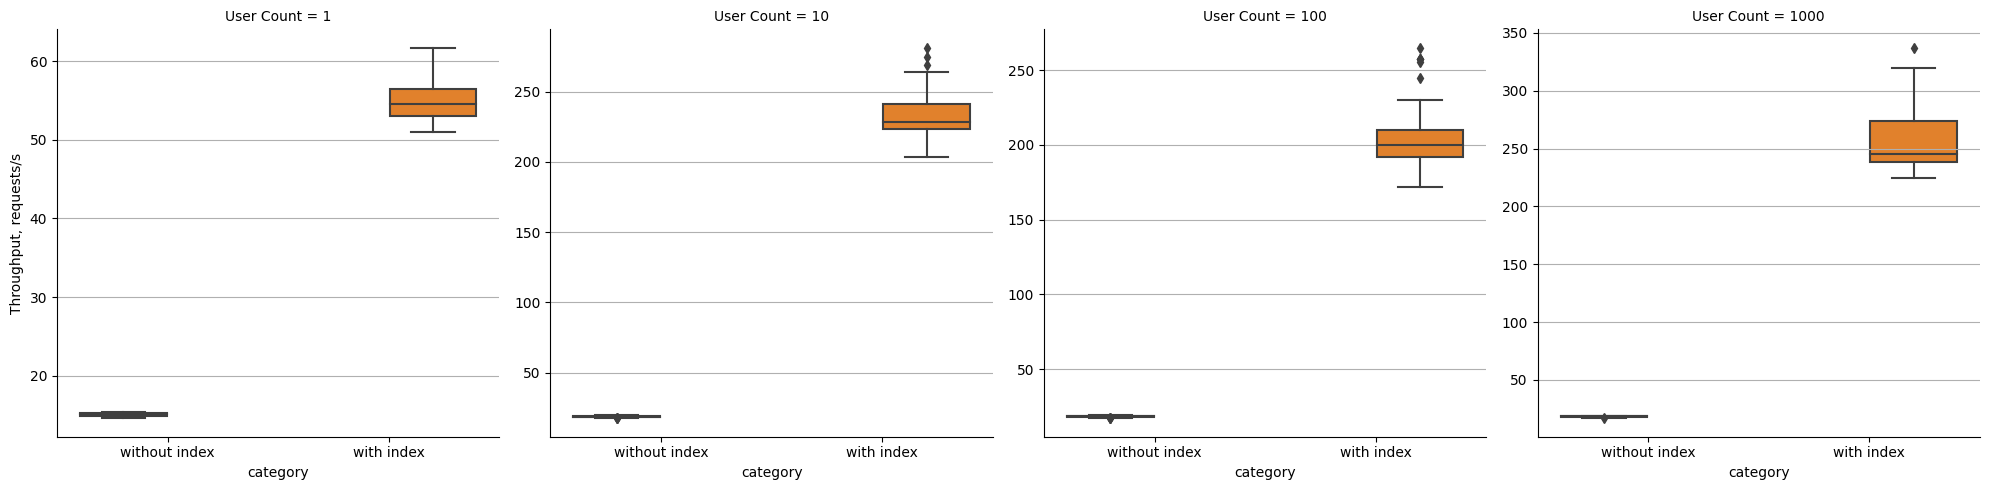

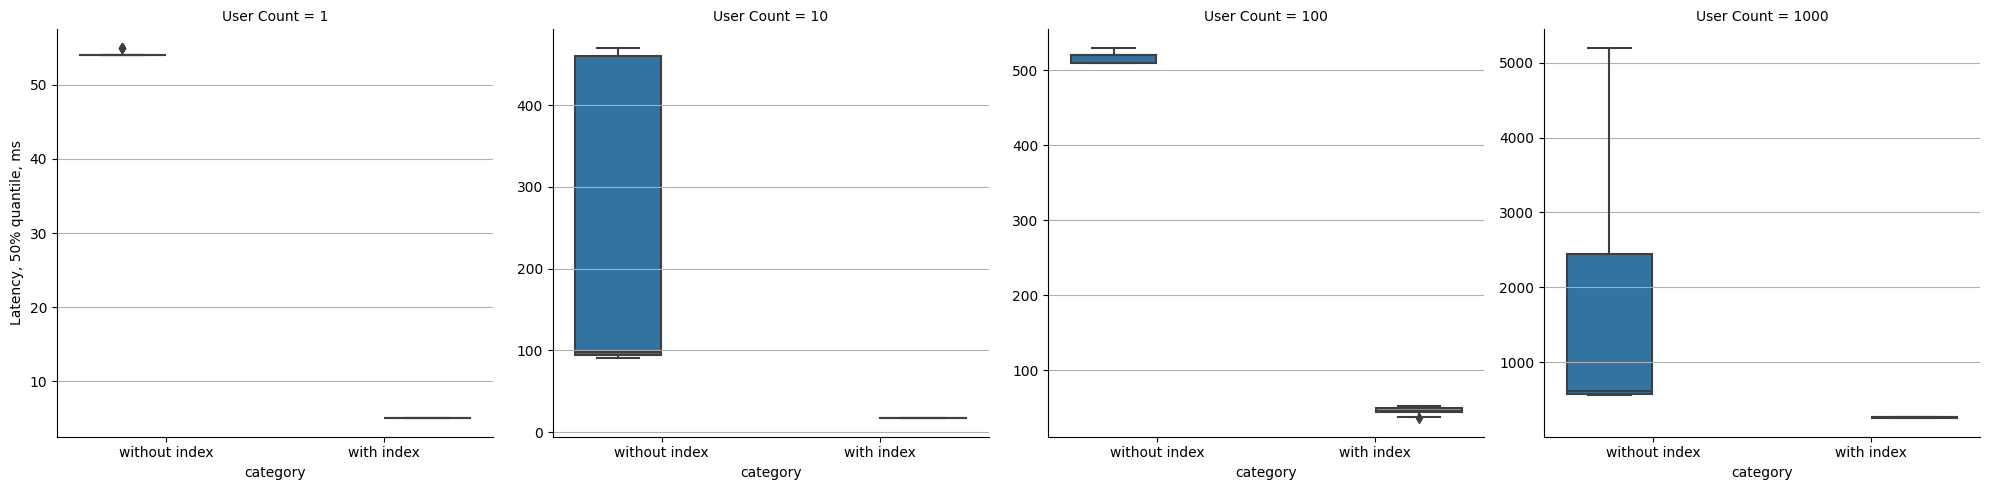

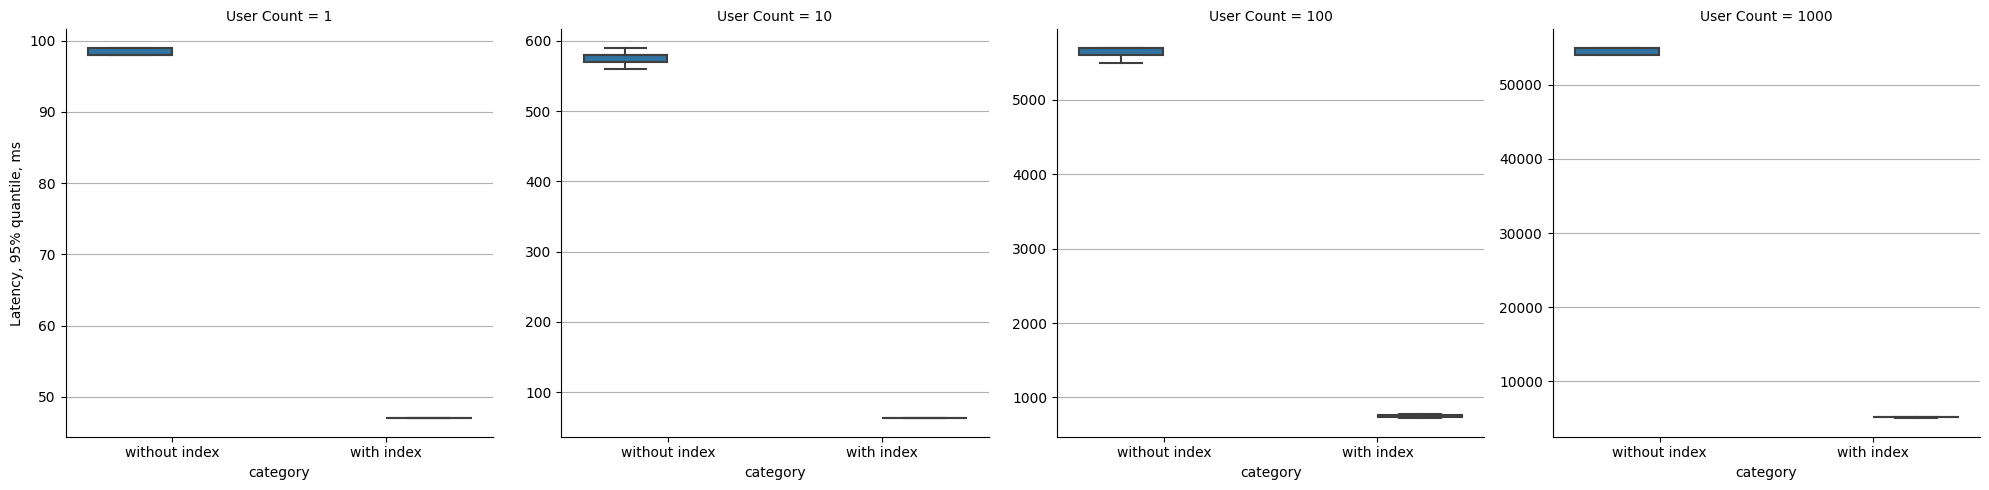

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def process_df(df):
    df['num_in_phase'] = df.groupby('User Count').cumcount() + 1
    df = df[df['num_in_phase'] >= 100]
    return df[['User Count', 'Requests/s', '50%', '90%', '95%']]

def plot(df, column, title):
    fig, ax = plt.subplots(figsize=(7, 5))

    sns.boxplot(data=df, x="User Count", y=column, hue="category", ax=ax)
    ax.grid()
    ax.set_yscale('log')
    ax.set_title(title)

    return fig, ax

def plot2(df, column, title):
    df = df.rename(columns={column: title})

    plot = sns.catplot(
        data=df, kind="box",
        x="category", y=title, hue="category", col="User Count",
        sharey=False
    )

    [ax.grid(axis='y') for ax in plot.axes.flatten()]

    return plot

df_before_index = pd.read_csv('001_search_user_without_index/loadtest_stats_history.csv')
df_after_index = pd.read_csv('002_search_user_with_index/loadtest_stats_history.csv')

df_before_index = process_df(df_before_index)
df_after_index = process_df(df_after_index)

df_before_index['category'] = 'without index'
df_after_index['category'] = 'with index'

df = pd.concat([df_before_index, df_after_index])

plot2(df, 'Requests/s', 'Throughput, requests/s')
plot2(df, '50%', 'Latency, 50% quantile, ms')
plot2(df, '95%', 'Latency, 95% quantile, ms')